In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



In [24]:
enc = LabelEncoder()

sports_tweets = pd.read_csv("CleanedSportsTweets2.csv")

# Encode the Sport feature using a new column labeled "Sport_Cat"
sports_tweets["Sport_Cat"] = enc.fit_transform(sports_tweets["Sport"])

In [25]:
X = sports_tweets["Tweet"]
y = sports_tweets["Sport_Cat"]

# Create the Vectorizer that uses both unigrams and bigrams with tuple (1, 2)
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

In [26]:
# Create x_fit which holds the fitted x to include those unigrams and bigrams
X_fit = tfidf.fit_transform(X)

# Use Stratified K Fold with 10 folds to use for cross validation
skfold = StratifiedKFold(n_splits = 10)

In [27]:
# Create the classifiers
lin_svc = LinearSVC()
rbf_svc = SVC()
knn = KNeighborsClassifier()
log_reg = LogisticRegression()
rfc = RandomForestClassifier(n_estimators=50)

In [28]:
def average(arr) -> float:
    # Returns the average of the array, arr, as a float
    return sum(arr) / len(arr)

In [29]:
# Split the data with an 80-20% split for training and testing where the model exclusively uses the 80% training data

X_train, X_test, y_train, y_test = train_test_split(X_fit, y, test_size=0.2)

In [30]:
# Test each classifier with cross validation using Stratified K Fold with the 80% training data
lin_svc_scores = cross_val_score(lin_svc, X_train, y_train, cv=skfold)
rbf_svc_scores = cross_val_score(rbf_svc, X_train, y_train, cv=skfold)
knn_scores = cross_val_score(knn, X_train, y_train, cv=skfold)
log_reg_scores = cross_val_score(log_reg, X_train, y_train, cv=skfold)
rfc_scores = cross_val_score(rfc, X_train, y_train, cv=skfold)


In [31]:
# Create functions to choose the highest performing model
def choose_classifier(lin_svc, rbf_svc, knn, log_reg, rfc):
    empty_dict = {}
    empty_dict["lin_svc"] = average(lin_svc_scores)
    empty_dict["rbf_svc"] = average(rbf_svc_scores)
    empty_dict["knn"] = average(knn_scores)
    empty_dict["log"] = average(log_reg_scores)
    empty_dict["rfc"] = average(rfc_scores)

    return string_to_classifier(max(empty_dict, key=empty_dict.get))

def string_to_classifier(string):
    if string == "lin_svc":
        return "Linear SVC Classifier"
    elif string == "rbf_svc":
        return "RBF Kernel SVM Classifier"
    elif string == "knn":
        return "K-Nearest Neighbors Classifier"
    elif string == "log":
        return "Logarithmic Regression Classifier"
    elif string == "rfc":
        return "Random Forest Classifier"
# Choose correct classifier with the highest average score
classifier_str = choose_classifier(lin_svc, rbf_svc, knn, log_reg, rfc)
classifier_str

'Random Forest Classifier'

In [32]:
# Since the Random Forest Classifier was the highest performing model
# We need to tune the hyperparameters for it to return the highest accuracy with 3 folds
# Specifically the n_estimaters paramater will be used to find the correct one

n_estimators = [10, 30, 50, 75, 100, 200, 300, 400, 500]

train_scores_n_estimators, test_scores_n_estimators = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = n_estimators, cv = 3)

# Create a list of hyperparamaters to use
chosen_hyperparameters = []


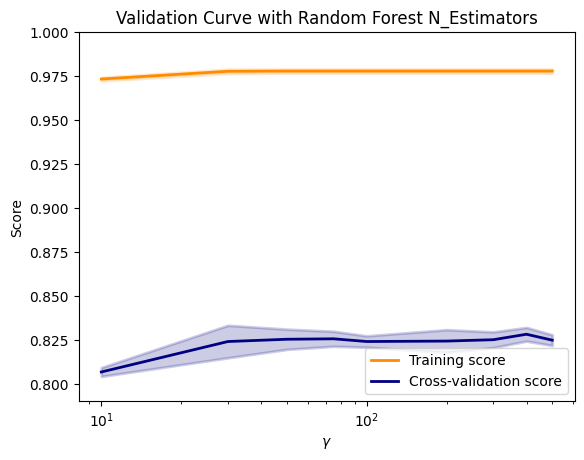

In [33]:
# Create a graph plotting these scores
train_scores_mean_n_estimators = np.mean(train_scores_n_estimators, axis=1)
train_scores_std_n_estimators = np.std(train_scores_n_estimators, axis=1)
test_scores_mean_n_estimators = np.mean(test_scores_n_estimators, axis=1)
test_scores_std_n_estimators = np.std(test_scores_n_estimators, axis=1)


plt.title("Validation Curve with Random Forest N_Estimators")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.79, 1.0)
lw = 2
plt.semilogx(
    n_estimators, train_scores_mean_n_estimators, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    n_estimators,
    train_scores_mean_n_estimators - train_scores_std_n_estimators,
    train_scores_mean_n_estimators + train_scores_std_n_estimators,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    n_estimators, test_scores_mean_n_estimators, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    n_estimators,
    test_scores_mean_n_estimators - test_scores_std_n_estimators,
    test_scores_mean_n_estimators + test_scores_std_n_estimators,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()


In [34]:
# Within the graph above we can see that the score stabilizes after the n_estimators count reaches around 100
# So any n_estimators after 100 will sufifce but we will grab the highest score just to be safe
# Gets the index of the highest n_estimator
list_test_score_mean_n_estimators = test_scores_mean_n_estimators.tolist()
max_index = list_test_score_mean_n_estimators.index(max(list_test_score_mean_n_estimators))

# Assign chosen_n_estimator to be equal to the highest performing n_estimator
chosen_n_estimator = n_estimators[max_index]

chosen_hyperparameters.append(chosen_n_estimator)

chosen_n_estimator

400

In [35]:
# Performing similar actions for max_depth hyperparameter
max_depths = [25, 30, 40, 45, 50, 60, 65, 75, 80, 90, 100]

train_scores_depth, test_scores_depth = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = max_depths, cv = 5)



In [36]:
test_scores_mean_depth = np.mean(test_scores_depth, axis=1)

list_test_score_mean_depth = test_scores_mean_depth.tolist()
max_index = list_test_score_mean_depth.index(max(list_test_score_mean_depth))

chosen_hyperparameters.append(max_depths[max_index])

In [37]:
# Performing similar actions for min_samples_split hyperparameter
min_sample_splits = [1, 2, 3, 5, 10, 15, 20, 25, 30]

train_scores_split, test_scores_split = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'min_samples_split', 
                                param_range = min_sample_splits, cv = 5)


In [38]:
test_scores_mean_split = np.mean(test_scores_split, axis=1)

list_test_score_mean_split = test_scores_mean_split.tolist()
max_index = list_test_score_mean_split.index(max(list_test_score_mean_split))

chosen_hyperparameters.append(min_sample_splits[max_index])

In [39]:
# Performing similar actions for min_samples_leaf hyperparameter
min_sample_leafs = [1, 2, 3, 4, 5, 6, 7, 8, 10, 15]

train_scores_leafs, test_scores_leafs = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'min_samples_leaf', 
                                param_range = min_sample_leafs, cv = 5)

In [40]:
train_score_mean_leafs = np.mean(train_scores_leafs, axis=1)
test_scores_mean_leafs = np.mean(test_scores_leafs, axis=1)

list_test_score_mean_leafs = test_scores_mean_leafs.tolist()
max_index = list_test_score_mean_leafs.index(max(list_test_score_mean_leafs))

chosen_hyperparameters.append(min_sample_leafs[max_index])

In [41]:
# Create the Random Forest Classifier with the selected n_estimator hyperparameter
classifier = RandomForestClassifier(n_estimators=chosen_hyperparameters[0], max_depth=chosen_hyperparameters[1], min_samples_split=chosen_hyperparameters[2], min_samples_leaf=chosen_hyperparameters[3])

In [42]:
# Use the training data to fit the chosen classifier model 
X = classifier.fit(X_train, y_train)
X.score(X_test, y_test)

# Use the model to predict the testing data
y_pred = classifier.predict(X_test)


In [43]:
# Compare the predictions to the actual output/label
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.66      0.74       191
           1       0.96      0.73      0.83        71
           2       0.78      0.98      0.87       461
           3       0.98      0.70      0.81        82
           4       0.89      0.67      0.77       163

    accuracy                           0.83       968
   macro avg       0.89      0.75      0.81       968
weighted avg       0.84      0.83      0.82       968

